### Áí∞Â¢ÉÂàùÂßãÂåñËàáÂ•ó‰ª∂ËºâÂÖ•  
ÊéõËºâ Google Drive„ÄÅÂàáÊèõÁõÆÈåÑÔºå‰∏¶ËºâÂÖ•ÊâÄÈúÄÁöÑ Python Â•ó‰ª∂ÔºåÂåÖÊã¨Ë≥áÊñôËôïÁêÜ„ÄÅÂµåÂÖ•Ê®°Âûã„ÄÅ‰∏ªÈ°åÂª∫Ê®°„ÄÅÂàÜÈ°ûÂô®ËàáÁπ™ÂúñÊ®°ÁµÑ„ÄÇ


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA/project3') #ÂàáÊèõË©≤ÁõÆÈåÑ
os.listdir() #Á¢∫Ë™çÁõÆÈåÑÂÖßÂÆπ

Mounted at /content/drive


['Project3.ipynb',
 'classification_with_embeddings_group11.ipynb',
 'TaipeiSansTCBeta-Regular.ttf',
 'EBC',
 'dict',
 'gpt_api_key.txt',
 'bert.ipynb']

In [ ]:
# !pip install -U sentence-transformers

In [ ]:
# !pip install bertopic

In [ ]:
# !pip install openai

In [ ]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, models, util
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from matplotlib.font_manager import fontManager
import jieba
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from openai import OpenAI
import time
from tqdm import tqdm

### Áí∞Â¢ÉÂàùÂßãÂåñËàáÂ•ó‰ª∂ËºâÂÖ•  
ÊéõËºâ Google Drive„ÄÅÂàáÊèõÁõÆÈåÑÔºå‰∏¶ËºâÂÖ•ÊâÄÈúÄÁöÑ Python Â•ó‰ª∂ÔºåÂåÖÊã¨Ë≥áÊñôËôïÁêÜ„ÄÅÂµåÂÖ•Ê®°Âûã„ÄÅ‰∏ªÈ°åÂª∫Ê®°„ÄÅÂàÜÈ°ûÂô®ËàáÁπ™ÂúñÊ®°ÁµÑ„ÄÇ


In [ ]:
# Ë®≠ÂÆöÂ≠óÈ´î
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

### ËºâÂÖ•‰∏≠ÊñáË™ûÊÑèÂµåÂÖ•Ê®°ÂûãÔºàBERTÔºâ
‰ΩøÁî® `SentenceTransformer` ËºâÂÖ• `google-bert/bert-base-chinese` Ê®°ÂûãÔºåÂ∞á‰∏≠ÊñáÂè•Â≠êËΩâÊèõÁÇ∫Ë™ûÊÑèÂêëÈáèÔºå‰ΩúÁÇ∫‰∏ªÈ°åÂª∫Ê®°ËàáÂàÜÈ°ûÁöÑÂü∫Á§é„ÄÇ


In [ ]:
# ‰∏≠Êñá bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device='cuda')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

### Step 1ÔºöË≥áÊñôËÆÄÂèñËàáÊ∏ÖÊ¥ó  
ËÆÄÂèñÂ§öÂÄã CSV Ê†ºÂºèÁöÑÊñ∞ËÅûË≥áÊñôÔºåÂêà‰ΩµÊàêÂñÆ‰∏Ä DataFrameÔºå‰∏¶Ê∏ÖÈô§Áº∫ÊºèÂÄº„ÄÅÁ∂≤ÂùÄ„ÄÅÈùû‰∏≠ÊñáÁ¨¶ËôüÁ≠âÈõúË®äË≥áÊñô„ÄÇÊúÄÁµÇ‰øùÁïôÊñáÁ´†ÂÖßÂÆπËàáÂàÜÈ°ûÊ¨Ñ‰Ωç‰æõÂæåÁ∫å‰ΩøÁî®„ÄÇ


In [ ]:
# ÂèñÂæóË≥áÊñôÂ§æ‰∏≠ÊâÄÊúâEBCÂêÑÁâàÂà•‰πã CSV Ê™îÊ°àÂêçÁ®±
folder_path =("./EBC")
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# ËÆÄÂèñ‰∏¶Âêà‰Ωµ
df_list = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
ebc = pd.concat(df_list, ignore_index=True)

# ËΩâÊèõÊó•ÊúüÊ¨Ñ‰ΩçÁÇ∫ datetime Ê†ºÂºè
ebc['artDate'] = pd.to_datetime(ebc['artDate'], errors='coerce')

# È°ØÁ§∫Âêà‰ΩµÂæåÁöÑ DataFrame ÂâçÂπæÁ≠Ü
ebc.head(3)

# ÁúãÁúãÊúâÂπæÁØáÊñáÁ´†
print(f"number of posts: {ebc.shape[0]}")
print(f"date range: {(ebc['artDate'].min(), ebc['artDate'].max())}")
print(f"category: \n{ebc['artCatagory'].value_counts()}")

number of posts: 6309
date range: (Timestamp('2024-09-01 06:00:00'), Timestamp('2025-02-28 22:57:00'))
category: 
artCatagory
ÂúãÈöõ    2644
È´îËÇ≤    1621
Ë≤°Á∂ì     980
Name: count, dtype: int64


In [ ]:
# ÈÅéÊøæ nan ÁöÑË≥áÊñô
ebc=ebc.dropna(subset=['artTitle'])
ebc = ebc.dropna(subset=['artContent'])
# ÁßªÈô§Á∂≤ÂùÄÊ†ºÂºè
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# Âè™Áïô‰∏ã‰∏≠ÊñáÂ≠ó
ebc["artContent"] = ebc.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc["artTitle"] = ebc["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
ebc.head(3)

# Áïô‰∏ã content
ebc["content"] = ebc["artTitle"] + ebc["artContent"]
ebc = ebc[["content", "artUrl", "artCatagory"]]  # ÊñáÁ´†ÂÖßÂÆπ ÊñáÁ´†ÈÄ£Áµê
ebc.head()

content  \
0  Êµ∑ÊôØËßÄÂÖâÊÆòÁ†¥‰∏çÂ†™ÂúãÊóÖË°∞Êïó‰∏ÄÁâáÂìÄÂöéË≥¥Ê∏ÖÂæ∑Á∏ΩÁµ±ÊõæÂñäÂá∫ËßÄÂÖâÁ´ãÂúãÁöÑÊîøË¶ã‰ΩÜÂπ¥Âà∞ÊúàÁÇ∫Ê≠¢ÂÖ•Âá∫Â¢ÉËßÄÂÖâÈÄÜÂ∑ÆÂ∑≤Á∂ì...   
1  ‰Ω≥‰∏ñÈÅîÂØ¶ÊñΩÂ∫´ËóèËÇ°Ë∑≥Á©∫Â§ßÊº≤Âè∞ËÇ°ÈáèÁ∏ÆÈúáÁõ™Êº≤ÁôæÈªûÂè∞ËÇ°‰ªäÊó•ÈñãÈ´òÈúáÁõ™Êó©Áõ§ÊåáÊï∏ÊúÄÈ´ò‰æÜÂà∞ÈªûÊº≤ÈÄæÈªûÈö®ÂæåÂá∫ÁèæÊãâ...   
2  ‰∫∫ÈÉΩÂéªÂì™‰∫ÜÂè∞ËÇ°ÂÜçÂâµÊñ∞‰ΩéÈáèÊî∂Ë∑åÈªûÂè∞ËÇ°‰ªäÊó•ÈñãÈ´òËµ∞‰ΩéÊî∂ÈªûÊî∂Ë∑åÈªûÊàê‰∫§ÈáèÁ∏ÆÊ∏õËá≥ÂÑÑÂÜçÂâµËæ≤ÊõÜÂπ¥ÂæåÊúÄ‰ΩéÈáèÊ´ÉË≤∑...   
3  Â§ßÂÆ∂‰∏çÁé©‰∫ÜÂè∞ËÇ°Âπ≥Áõ§ÈúáÁõ™‰º∞ÈáèÂÉÖÂÑÑÂè∞ËÇ°‰ªäÊó•ÈáèÁ∏ÆÈúáÁõ™ÊåáÊï∏Âú®Âπ≥Áõ§ÈôÑËøëÈúáÁõ™Êó©Áõ§ÊúÄ‰Ωé‰∏ãÊé¢ÈªûË∑åÈÄæÈªûÈ†ê‰º∞Êàê‰∫§...   
4  Âø´Ë®äÂê≥Êù±‰∫ÆÊ∂âÊª≤ÈÄèÊñ∞ÂÖâÈáëÊúâÈóúÈçµÈü≥Ê™îÂåóÊ™¢ÂàÜÊ°àÂÅµËæ¶‰∏≠Êñ∞ÂÖâÈáëÂíåÂè∞Êñ∞ÈáëÂêà‰ΩµÁèæÂú®ÁàÜÂá∫ÊúâÂÖßÈ¨ºÂè∞ÂåóÂú∞Ê™¢ÁΩ≤Êé•Âà∞...   

                                         artUrl artCatagory  
0  https://news.ebc.net.tw/news/business/440092          Ë≤°Á∂ì  
1  https://news.ebc.net.tw/news/business/440373          Ë≤°Á∂ì  
2  https://news.ebc.net.tw/news/business/440428          Ë≤°Á∂ì  
3  https://news.ebc.net.tw/news/business/440550          Ë≤°Á∂ì  
4  https://news.ebc.net.tw/news/business/440566          Ë≤°Á∂ì

### ÁîüÊàêÂµåÂÖ•ÂêëÈáè  
Â∞áÊØèÁØáÊñáÁ´†ÁöÑ `content` ËΩâÊèõÊàêË™ûÊÑèÂêëÈáèÔºå‰∏¶Â≠òÂÖ•Êñ∞ÁöÑÊ¨Ñ‰Ωç `embeddings`Ôºå‰ΩúÁÇ∫ÂæåÁ∫åÁõ£Áù£ÂºèÂ≠∏ÁøíËàá‰∏ªÈ°åÂª∫Ê®°ÁöÑËº∏ÂÖ•ÁâπÂæµ„ÄÇ


In [ ]:
ebc["embeddings"] = ebc.content.apply(lambda x: bert_ch.encode(x))
ebc.head(3)

content  \
0  Êµ∑ÊôØËßÄÂÖâÊÆòÁ†¥‰∏çÂ†™ÂúãÊóÖË°∞Êïó‰∏ÄÁâáÂìÄÂöéË≥¥Ê∏ÖÂæ∑Á∏ΩÁµ±ÊõæÂñäÂá∫ËßÄÂÖâÁ´ãÂúãÁöÑÊîøË¶ã‰ΩÜÂπ¥Âà∞ÊúàÁÇ∫Ê≠¢ÂÖ•Âá∫Â¢ÉËßÄÂÖâÈÄÜÂ∑ÆÂ∑≤Á∂ì...   
1  ‰Ω≥‰∏ñÈÅîÂØ¶ÊñΩÂ∫´ËóèËÇ°Ë∑≥Á©∫Â§ßÊº≤Âè∞ËÇ°ÈáèÁ∏ÆÈúáÁõ™Êº≤ÁôæÈªûÂè∞ËÇ°‰ªäÊó•ÈñãÈ´òÈúáÁõ™Êó©Áõ§ÊåáÊï∏ÊúÄÈ´ò‰æÜÂà∞ÈªûÊº≤ÈÄæÈªûÈö®ÂæåÂá∫ÁèæÊãâ...   
2  ‰∫∫ÈÉΩÂéªÂì™‰∫ÜÂè∞ËÇ°ÂÜçÂâµÊñ∞‰ΩéÈáèÊî∂Ë∑åÈªûÂè∞ËÇ°‰ªäÊó•ÈñãÈ´òËµ∞‰ΩéÊî∂ÈªûÊî∂Ë∑åÈªûÊàê‰∫§ÈáèÁ∏ÆÊ∏õËá≥ÂÑÑÂÜçÂâµËæ≤ÊõÜÂπ¥ÂæåÊúÄ‰ΩéÈáèÊ´ÉË≤∑...   

                                         artUrl artCatagory  \
0  https://news.ebc.net.tw/news/business/440092          Ë≤°Á∂ì   
1  https://news.ebc.net.tw/news/business/440373          Ë≤°Á∂ì   
2  https://news.ebc.net.tw/news/business/440428          Ë≤°Á∂ì   

                                          embeddings  
0  [0.4972598, -0.021271732, -0.09516859, 0.21490...  
1  [0.46630383, -0.11442908, -0.77415943, 0.37873...  
2  [0.5071892, -0.031903733, -0.5426887, 0.264808...

### Step 2ÔºöÁõ£Áù£ÂºèÂàÜÈ°ûÊ®°ÂûãË®ìÁ∑¥ËàáË©ï‰º∞  
Â∞áÂµåÂÖ•ÂêëÈáè‰ΩúÁÇ∫ÁâπÂæµÔºåÊñáÁ´†È°ûÂà•‰ΩúÁÇ∫Ê®ôÁ±§Ôºå‰ΩøÁî® 4 Á®ÆÁõ£Áù£ÂºèÊ®°ÂûãÔºàLogistic Regression„ÄÅDecision Tree„ÄÅSVM„ÄÅRandom ForestÔºâÈÄ≤Ë°å‰∫îÊäò‰∫§ÂèâÈ©óË≠âÔºå‰∏¶Ëº∏Âá∫ÂàÜÈ°ûÂ†±ÂëäËàáÊ∑∑Ê∑ÜÁü©Èô£„ÄÇ


In [ ]:
import numpy as np
from ast import literal_eval

In [ ]:
data = ebc.copy()

X = data["embeddings"].apply(pd.Series)
y = data["artCatagory"]

# ÊääÊï¥ÂÄãË≥áÊñôÈõÜ‰∏É‰∏âÂàá
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

           0         1         2         3         4         5         6    \
1113  0.433784 -0.167597 -0.055715  0.144849  0.013170 -0.179081 -0.021578   
3051  0.196818  0.057188 -0.068721  0.220140 -0.097643 -0.059463  0.031373   
1640  0.610920 -0.063231 -0.238010  0.250306 -0.077395 -0.363956  0.170794   
6075  0.339784 -0.264978 -0.404218 -0.028292  0.094855  0.019311  0.133041   
3915  0.491078 -0.243066 -0.320898  0.397925  0.002738 -0.063596 -0.142421   

           7         8         9    ...       758       759       760  \
1113  0.259486 -0.332629 -0.118738  ... -0.203510 -0.254922  0.081344   
3051  0.176571 -0.322203 -0.290317  ...  0.085174 -0.307107  0.074841   
1640  0.127581 -0.230564 -0.174639  ...  0.117371 -0.455117  0.053569   
6075  0.058468 -0.243618 -0.230758  ...  0.038889 -0.239554  0.249741   
3915  0.073776 -0.440095 -0.183398  ...  0.080345 -0.315782  0.008833   

           761       762       763       764       765       766       767  
1113 -0.052050 

In [ ]:
# ÂÆöÁæ©Ê®°ÂûãÊ∏ÖÂñÆ
model_set = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'RandomForest': RandomForestClassifier()}
result_set = {}

def train_sbert_classifier(clf, X, y):
    # Cross-validation (5 folds)
    cv_results = cross_validate(clf, X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))
    classes = cv_results['estimator'][0].classes_
    cm = confusion_matrix(y, y_pred)
    # Áï´ confusion matrix
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{clf.__class__.__name__} Confusion Matrix")
    plt.yticks(rotation=0)
    plt.show()
    return cls_report

### ÊØîËºÉ F1-score ‰∏¶ÈÅ∏Âá∫ÊúÄ‰Ω≥Ê®°Âûã  
Ë®àÁÆóÊØèÂÄãÊ®°ÂûãÁöÑ weighted average F1-scoreÔºåÈÅ∏Âá∫Ë°®ÁèæÊúÄ‰Ω≥ËÄÖÔºå‰∏¶Âú®Ê∏¨Ë©¶ÈõÜ‰∏äËº∏Âá∫ÊúÄÁµÇÁöÑÂàÜÈ°ûÁµêÊûú„ÄÇ


Ë®ìÁ∑¥Ê®°ÂûãÔºöLogisticRegression
              precision    recall  f1-score   support

          ÂúãÈöõ       0.97      0.98      0.97      1864
          Ë≤°Á∂ì       0.95      0.93      0.94       676
          È´îËÇ≤       0.99      0.99      0.99      1131

    accuracy                           0.97      3671
   macro avg       0.97      0.96      0.97      3671
weighted avg       0.97      0.97      0.97      3671



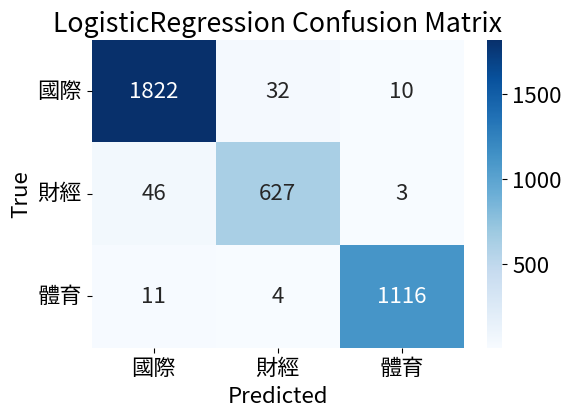

Ë®ìÁ∑¥Ê®°ÂûãÔºöDecisionTree
              precision    recall  f1-score   support

          ÂúãÈöõ       0.89      0.88      0.89      1864
          Ë≤°Á∂ì       0.76      0.78      0.77       676
          È´îËÇ≤       0.89      0.89      0.89      1131

    accuracy                           0.87      3671
   macro avg       0.85      0.85      0.85      3671
weighted avg       0.87      0.87      0.87      3671



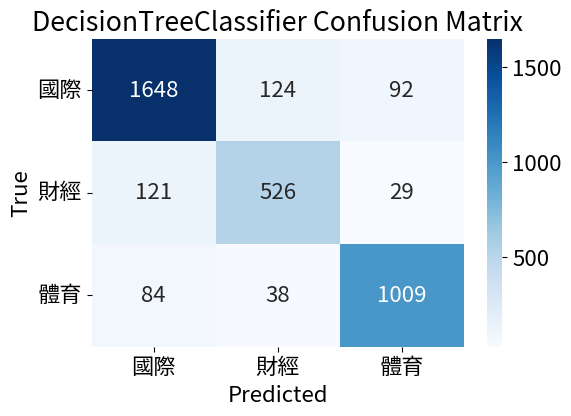

Ë®ìÁ∑¥Ê®°ÂûãÔºöSVM
              precision    recall  f1-score   support

          ÂúãÈöõ       0.95      0.98      0.96      1864
          Ë≤°Á∂ì       0.95      0.88      0.91       676
          È´îËÇ≤       0.99      0.98      0.99      1131

    accuracy                           0.96      3671
   macro avg       0.96      0.95      0.95      3671
weighted avg       0.96      0.96      0.96      3671



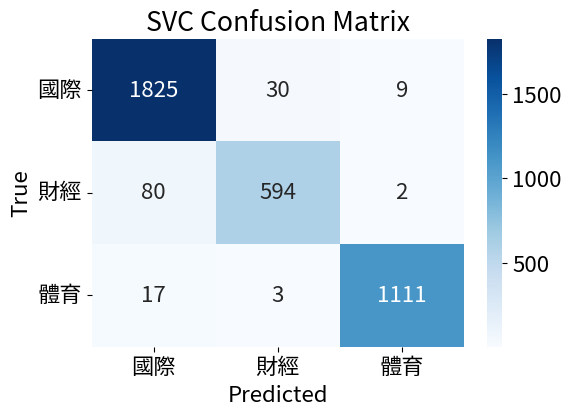

Ë®ìÁ∑¥Ê®°ÂûãÔºöRandomForest
              precision    recall  f1-score   support

          ÂúãÈöõ       0.93      0.99      0.96      1864
          Ë≤°Á∂ì       0.96      0.84      0.89       676
          È´îËÇ≤       0.99      0.96      0.98      1131

    accuracy                           0.95      3671
   macro avg       0.96      0.93      0.94      3671
weighted avg       0.95      0.95      0.95      3671



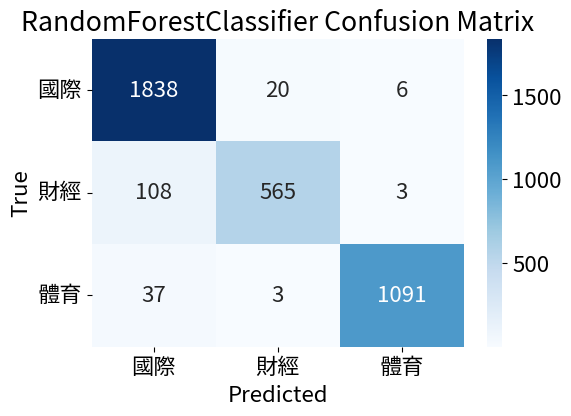


‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÔºöLogisticRegressionÔºåF1-score = 0.9711
{'accuracy': 0.9711250340506674,
 'macro avg': {'f1-score': 0.9658936793987939,
               'precision': 0.9679504860122893,
               'recall': 0.9639066681962368,
               'support': 3671.0},
 'weighted avg': {'f1-score': 0.9710632959824177,
                  'precision': 0.9710504270467287,
                  'recall': 0.9711250340506674,
                  'support': 3671.0},
 'ÂúãÈöõ': {'f1-score': 0.9735506278386321,
        'precision': 0.9696647152740819,
        'recall': 0.9774678111587983,
        'support': 1864.0},
 'Ë≤°Á∂ì': {'f1-score': 0.936519790888723,
        'precision': 0.9457013574660633,
        'recall': 0.9275147928994083,
        'support': 676.0},
 'È´îËÇ≤': {'f1-score': 0.9876106194690265,
        'precision': 0.9884853852967228,
        'recall': 0.986737400530504,
        'support': 1131.0}}


In [ ]:
# Âü∑Ë°åÊâÄÊúâÊ®°ÂûãË®ìÁ∑¥ + Ë©ï‰º∞
for name, model in model_set.items():
    print("=" * 100)
    print(f"Ë®ìÁ∑¥Ê®°ÂûãÔºö{name}")
    result_set[name] = train_sbert_classifier(model, X_train, y_train)
    print("=" * 100)

# ÊâæÂá∫ F1-score ÊúÄ‰Ω≥Ê®°Âûã
best_model_name = ""
max_f1 = 0
for name, report in result_set.items():
    if report['weighted avg']['f1-score'] > max_f1:
        max_f1 = report['weighted avg']['f1-score']
        best_model_name = name

print(f"\n‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÔºö{best_model_name}ÔºåF1-score = {max_f1:.4f}")
pprint(result_set[best_model_name])

In [ ]:
# Best modelÊúÄÂæåÁµêÊûú
final_clf = model_set[best_model_name]
final_clf.fit(X_train, y_train)
y_pred = final_clf.predict(X_test)
print(f"\nüìä Best model {best_model_name} ÁöÑÊ∏¨Ë©¶ÈõÜÂàÜÈ°ûÁµêÊûúÔºö")
print(classification_report(y_test, y_pred))
print(y_pred[:10])


üìä Best model LogisticRegression ÁöÑÊ∏¨Ë©¶ÈõÜÂàÜÈ°ûÁµêÊûúÔºö
              precision    recall  f1-score   support

          ÂúãÈöõ       0.97      0.97      0.97       780
          Ë≤°Á∂ì       0.94      0.93      0.94       304
          È´îËÇ≤       0.98      0.99      0.99       490

    accuracy                           0.97      1574
   macro avg       0.96      0.96      0.96      1574
weighted avg       0.97      0.97      0.97      1574

['Ë≤°Á∂ì' 'ÂúãÈöõ' 'È´îËÇ≤' 'ÂúãÈöõ' 'È´îËÇ≤' 'Ë≤°Á∂ì' 'ÂúãÈöõ' 'Ë≤°Á∂ì' 'È´îËÇ≤' 'È´îËÇ≤']


### Step 3Ôºö‰∏ªÈ°åÂª∫Ê®°Ê∫ñÂÇôËàáÊ®°ÂûãÊßãÂª∫  
Ë®≠ÂÆö `jieba` Â≠óÂÖ∏ËàáÂÅúÁî®Ë©ûÊ∏ÖÂñÆÔºåËá™ÂÆöÁæ© tokenizer Ëàá `CountVectorizer`ÔºåÁµêÂêà `HDBSCAN` Ëàá `SentenceTransformer` ÂêëÈáèÔºåÂª∫Á´ã BERTopic Ê®°Âûã„ÄÇ


In [ ]:
# Ë®≠ÂÆö jieba Ë©ûÂ∫´ËàáÂÅúÁî®Ë©û
jieba.set_dictionary('./dict/dict.txt.big')
with open('./dict/stopwords.txt', encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

In [ ]:
docs_zh = ebc["content"].to_list()
embeddings = ebc["embeddings"].to_list()
embeddings = np.array(embeddings)

### Âü∑Ë°å BERTopic Ê®°Âûã‰∏¶ÂèØË¶ñÂåñ‰∏ªÈ°å  
‰ΩøÁî® `.fit_transform()` Âü∑Ë°å‰∏ªÈ°åÂª∫Ê®°Ôºå‰∏¶ÈÄèÈÅé `.visualize_topics()` Áî¢Áîü‰∫íÂãïÂºè‰∏ªÈ°åË¶ñË¶∫ÂåñÁµêÊûú„ÄÇ


In [ ]:

hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=10)
# ‰∏≠ÊñáÂàÜË©ûÂáΩÊï∏
def tokenize_zh(text):
    return jieba.lcut(text)

# ‰ΩøÁî® jieba ÂàÜË©ûÁöÑ CountVectorizer
jieba_vectorizer = CountVectorizer(
    tokenizer=tokenize_zh,
    stop_words=stopwords,
    analyzer='word',
    token_pattern=u"(?u)\\b\\w+\\b"
)

# Âª∫Á´ã BERTopic Ê®°Âûã
zh_topic_model = BERTopic(
    embedding_model=bert_ch,
    vectorizer_model=jieba_vectorizer,
    hdbscan_model=hdbscan_model,
    verbose=True,
    top_n_words=30
)

# Âü∑Ë°åÊ®°ÂûãË®ìÁ∑¥
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)


2025-05-10 07:37:11,225 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 07:37:21,485 - BERTopic - Dimensionality - Completed ‚úì
2025-05-10 07:37:21,486 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 07:37:21,600 - BERTopic - Cluster - Completed ‚úì
2025-05-10 07:37:21,605 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 07:37:33,205 - BERTopic - Representation - Completed ‚úì


In [ ]:
zh_topic_model.get_topic_info().head(10)

Topic  Count            Name  \
0     -1    533  -1_ÁæéÂúã_‰∏≠Âúã_Êù±Ê£Æ_Âè∞ÁÅ£   
1      0   1487   0_‰∏≠ËèØÈöä_Âè∞ÁÅ£_Èô≥_Ê£íÁêÉ   
2      1   1299    1_‰∏ÄÂêç_Ê≠≤_Ë≠¶Êñπ_Áî∑Â≠ê   
3      2    180  2_Â∑ùÊôÆ_Ë≥ÄÈå¶È∫ó_Á∏ΩÁµ±_ÁæéÂúã   
4      3    168   3_ÊäïË≥á_Âè∞ËÇ°_Á∂≤Âèã_Â∏ÇÂ†¥   
5      4    147   4_Ëà™Á©∫_È£õÊ©ü_‰∫ãÊïÖ_Ê©üÂ†¥   
6      5    145   5_Âú∞Èúá_Â§ßÈõ™_Ê∞ëÁúæ_Á©çÈõ™   
7      6    137  6_Â∞πÈå´ÊÇÖ_ÊàíÂö¥_ÂçóÈüì_Á∏ΩÁµ±   
8      7    113   7_Êº≤ÂπÖ_Êî∂ÂÖÉ_Êº≤ÂÖÉ_ÊóèÁæ§   
9      8    113    8_Êó©Áõ§_‰æÜÂà∞_ÂÖÉÊº≤_ÂÖÉ   

                                      Representation  \
0  [ÁæéÂúã, ‰∏≠Âúã, Êù±Ê£Æ, Âè∞ÁÅ£, Êñ∞ËÅû,  , Â∑ùÊôÆ, ÂÖ¨Âè∏, Â∏ÇÂ†¥, ‰∏≠, ÈªÉÈáë, Â§ßÂ∞è‰∫ã...   
1  [‰∏≠ËèØÈöä, Âè∞ÁÅ£, Èô≥, Ê£íÁêÉ, ÊäïÊâã, ÁêÉËø∑, ‰∏ñÁïå, Á∂ìÂÖ∏, Ë≥Ω, ÊØîË≥Ω, ÁêÉÂì°, Êó•Êú¨...   
2  [‰∏ÄÂêç, Ê≠≤, Ë≠¶Êñπ, Áî∑Â≠ê, ÁôºÁîü, ÁôºÁèæ, Â•≥Â≠ê, Êñ∞ËÅû,  , ‰∏≠, ‰∫ã‰ª∂, Êù±Ê£Æ, ...   
3  [Â∑ùÊôÆ, Ë≥ÄÈå¶È∫ó, Á∏ΩÁµ±, ÁæéÂúã, ÂÄôÈÅ∏‰∫∫, Â∑û, ÊäïÁ•®, ÈÅ∏Ê∞ë, ÊãúÁôª, Ê∞ë‰∏ªÈª®, ËæØË´ñ,...   
4  [ÊäïË≥á, Âè∞ËÇ°, Á∂≤Âèã, Â∏ÇÂ†¥, Êù±Ê£Æ, ËÇ°Â∏Ç, ËÇ°ÂÉπ, ÊäïË≥á‰∫∫, Ë≤°Á∂ì, Ë≤∑, ËÇ°Á•®, Èôç...   
5  [Ëà™Á©∫, È£õÊ©ü, ‰∫ãÊïÖ, Ê©üÂ†¥, ÂÆ¢Ê©ü, Á©∫Èõ£, ÊøüÂ∑û, ÈôçËêΩ, ‰πòÂÆ¢, Áè≠Ê©ü, ‰∏ÄÊû∂, Ëà™...   
6  [Âú∞Èúá, Â§ßÈõ™, Ê∞ëÁúæ, Á©çÈõ™, Êó•Êú¨, Âú∞ÂçÄ, È¢±È¢®, ÁôºÁîü, ÂΩ±Èüø, Èôç‰∏ã, Ê¥™Ê∞¥, ÂÖ¨...   
7  [Â∞πÈå´ÊÇÖ, ÊàíÂö¥, ÂçóÈüì, Á∏ΩÁµ±, ÂúãÊúÉ, ÂΩàÂäæ, ÂΩàÂäæÊ°à, Âü∑ÊîøÈª®, ÂúãÊ∞ë, Âú®ÈáéÈª®, Ë≠∞...   
8  [Êº≤ÂπÖ, Êî∂ÂÖÉ, Êº≤ÂÖÉ, ÊóèÁæ§, Âè∞ËÇ°, ‰ΩúÊî∂, Êº≤ÂÅú, Êî∂Êº≤, ÂÖÉ, Ë∑åÂπÖ, ÁµÇÂ†¥, ‰ª•Èªû...   
9  [Êó©Áõ§, ‰æÜÂà∞, ÂÖÉÊº≤, ÂÖÉ, Êº≤ÂπÖ, ÈÄæ, ÊóèÁæ§, Âè∞ËÇ°, ÈúáÁõ™, ËÇ°, ÊúÄ‰Ωé, ‰∏ãÊé¢, ...   

                                 Representative_Docs  
0  [ÁÑ°Ë¶ñÂèçÂ∞çÂ∑ùÊôÆÈÄ†Âã¢ÂñäÁæéÂúãË£ΩÈÄ†Áî®ÈóúÁ®ÖÈ©ÖÂãïÁ∂ìÊøüÁπÅÊ¶ÆÁæéÂúãÂ§ßÈÅ∏ÂÄíÊï∏Ë®àÊôÇÂâçÁ∏ΩÁµ±Â∑ùÊôÆÁ©çÊ•µË∑ëÊêñÊì∫Â∑ûÈÄ†Âã¢ÊúÄËøë...  
1  [Âº∑ÁúãÊù±Ê£Æ‰∏≠ËèØÈöäË∏è‰∏äÊù±‰∫¨Â∑®ËõãÁêÉÊòüÊèÆÊ£íÁÜ±Ë∫´ÂÇôÊà∞ÂßîÂÖßÁëûÊãâÂè∞ÁÅ£Êå∫ÈÄ≤Âº∑Ë§áË≥ΩÊòéÂ§©Êó•Â∞±Ë¶ÅÂ∞çÊà∞ÂßîÂÖßÁëûÊãâ‰ªäÂ§©...  
2  [ÂçóÈüìÊ≠≤Â•≥Á´•ÈÅ≠ËÄÅÂ∏´ÊÆ∫ÂÆ≥Ë≠¶Âõ†ÂéüÂõ†ÁÑ°Ê≥ïÈÄÆÊçïÂá∂Â´åËøëÊó•ÂçóÈüìÂ§ßÁî∞Â∏Ç‰∏ÄÈñìÂ∞èÂ≠∏ÁôºÁîü‰∏ÄËµ∑ÈúáÈ©öÁ§æÊúÉÁöÑÈ©öÊÇöÂá∂ÊÆ∫Ê°à...  
3  [Â∞ÅÈóúÊ∞ëË™øÂíåÂ∑ùÊôÆÊâìÊàêÂπ≥ÊâãÊ∞ë‰∏ªÈª®Â∞çË≥ÄÈå¶È∫óÈÅ∏ÊÉÖÊÇ≤ËßÄÁæéÂúãÁ∏ΩÁµ±Â§ßÈÅ∏ÊúàËôüÂç≥Â∞áÁôªÂ†¥Á¥êÁ¥ÑÊôÇÂ†±ÁôºÂ∏ÉÈÅ∏ÂâçÊúÄÂæå‰∏Ä...  
4  [Âè∞ËÇ°‰∏äÁúãËê¨Á∂≤ÂñäÁÑ°ËÖ¶Ë≤∑Âè∞Á©çÊÆ∫Á†¥ÂçÉÂÖÉÂÖ®Êäñ‰∫ÜÂàÜÊûêÂ∏´ÂÖçÈ©öÂØåÈÇ¶ÊäïÈ°ßËë£‰∫ãÈï∑Èô≥Â•ïÂÖâÊó•ÂâçÂá∫Â∏≠ÂØåÈÇ¶Ë≤°Á∂ìË∂®Âã¢Ë´ñ...  
5  [Âø´Ë®äÊ≠ª‰∫°‰∫∫Êï∏Â¢ûËá≥‰∫∫ÂçóÈüìÂãôÂÆâÊ©üÂ†¥ÈóúÈñâËá≥ÂÖÉÊó¶ÊøüÂ∑ûËà™Á©∫‰∏ÄÊû∂ËºâÊúâ‰∫∫ÁöÑËà™Áè≠Ê≥¢Èü≥ÂÆ¢Ê©üÊñºÈüìÂúãÊôÇÈñì‰ªäÊó•‰∏äÂçà...  
6  [ÂàùÈõ™Âç≥Êö¥Èõ™È¶ñÁàæÂπ¥ÊúÄÂ§ßÈõ™Â±ãÈ†ÇË¢´Â£ìÂûÆËá≥Â∞ëÊ≠ªÂçóÈüìÂæûÂë®‰∫åÊôöÈñìÈñãÂßãÈôç‰∏ãÂ§ßÈõ™È¶ñÁàæ‰∏çÂÉÖÂâµ‰∏ãÂπ¥‰æÜÊúàÊúÄÂ§ßÈôçÈõ™...  
7  [ÂèçÂ∞çË¶™ÂåóÈüìÂã¢ÂäõÂçóÈüìÁ™ÅÂÆ£Â∏ÉÊàíÂö¥ÂÉÖÂ∞èÊôÇËêΩÂπïÂçóÈüìÁ∏ΩÁµ±Â∞πÈå´ÊÇÖÊò®ÊôöÁ™ÅË•≤ÂºèÂÆ£Â∏ÉÈÄ≤ÂÖ•Á∑äÊÄ•ÊàíÂö¥‰ª•‰øùË≠∑ÂúãÂÆ∂‰∏ç...  
8  [Ëê¨ËøëÈóúÊÉÖÊÄØÂè∞ËÇ°ÈñãÈ´òËµ∞‰ΩéÊî∂Êº≤ÈªûÂè∞ËÇ°‰ªäÊó•‰ª•Èªû‰ΩúÊî∂Êº≤ÈªûÊàê‰∫§ÈáèÁï•Ê∏õËá≥ÂÑÑÊ´ÉË≤∑ÊåáÊï∏Êó©Áõ§ÊúÄÈ´òÂâáÊî∂ÈªûÈõªÂ≠êÊ¨ä...  
9  [ÈõªÂ≠êÂÄí‰∏ÄÁâáÂè∞ËÇ°‰∏ãË∑åÈªûÂè∞Â°ëÂõõÂØ∂‰∏çÂøç‰∫ÜÈÄÜÂã¢ÊíêÁõ§Âè∞ËÇ°‰ªäÊó•Êó©Áõ§ÈñãÈ´òËµ∞‰ΩéÈñãÂ∞èÊº≤ÂæåÂá∫Áèæ‰∏ÄÊ≥¢ÊÄ•ÊÆ∫ÊúÄ‰Ωé‰∏ãÊé¢...

In [ ]:
zh_topic_model.visualize_topics()

In [ ]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [01:16<00:00, 12.83s/it]


In [ ]:
zh_topic_model.visualize_distribution(topic_distr[1])

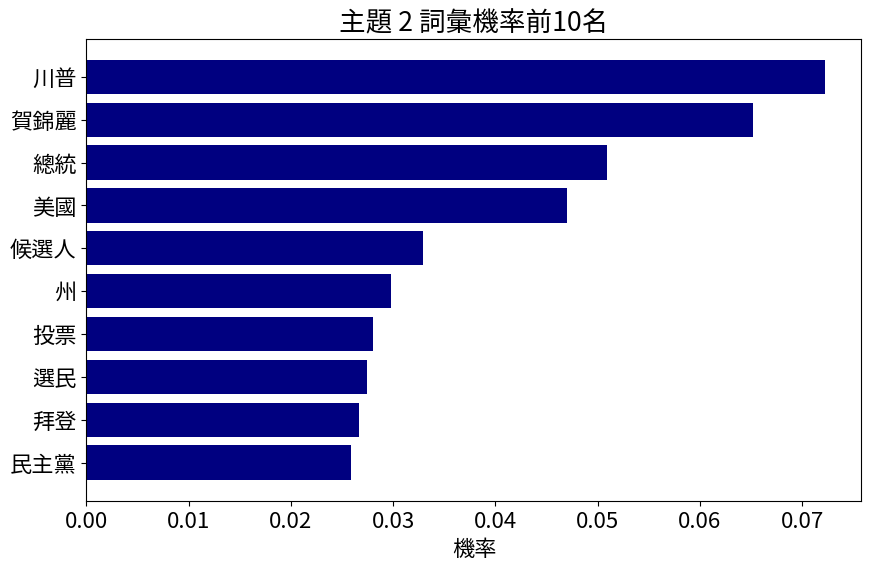

In [ ]:
# Ë¶ñË¶∫ÂåñÈ°ØÁ§∫‰∏ªÈ°å-Ë©ûÂΩôÂàÜ‰Ωà
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# ËΩâÊèõÁÇ∫DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# Ê†πÊìöprobÊéíÂ∫è‰∏¶ÈÅ∏Âá∫Ââç10Âêç
top_10 = df.sort_values('prob', ascending=False).head(10)

# Áï´Âá∫Èï∑Ê¢ùÂúñ
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('Ê©üÁéá')
plt.title(f'‰∏ªÈ°å {topic_n} Ë©ûÂΩôÊ©üÁéáÂâç10Âêç')
plt.gca().invert_yaxis()
plt.show()

### ËºâÂÖ• OpenAI API ‰∏¶ÂÆöÁæ© GPT Ë©ÆÈáãÂáΩÊï∏  
ËÆÄÂèñ API ÈáëÈë∞‰∏¶ÂÆöÁæ© `call_gpt()` ÂáΩÊï∏ÔºåÂ∞á‰∏ªÈ°åÈóúÈçµË©ûÈ§µÂÖ• GPT Ê®°ÂûãÔºåËÆìÂÖ∂Ëá™ÂãïÁî¢Áîü‰∏ªÈ°åÂàÜÈ°ûÔºà‰æãÂ¶ÇÔºöÈ´îËÇ≤„ÄÅÂúãÈöõ„ÄÅË≤°Á∂ìÔºâ„ÄÇ


In [ ]:
# ËÆÄÂèñAPI key
with open("gpt_api_key.txt", "r", encoding="utf-8") as f:
    key = f.read().strip()

In [ ]:
client = OpenAI(api_key=key)
def call_gpt(keywords):
    try:
        prompt = f"""
            ‰ª•‰∏ãÊòØ‰∏ÄÁæ§Êñ∞ËÅûÊñáÁ´†ÁöÑ‰ª£Ë°®ÊÄßÈóúÈçµË©ûÔºö{', '.join(keywords)}
            Ë´ãÂà§Êñ∑ÈÄô‰∫õÈóúÈçµË©ûÊúÄÊúâÂèØËÉΩÂ±¨ÊñºÂì™‰∏ÄÈ°ûÊñ∞ËÅû‰∏ªÈ°åÔºüÔºàË´ãÂè™ÂõûË¶ÜÔºöÈ´îËÇ≤„ÄÅÂúãÈöõ„ÄÅË≤°Á∂ìÔºâ
        """
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.8
        )
        output = response.choices[0].message.content.strip()
        return output
    except Exception as e:
        print(f"‚ö†Ô∏è Error: {e}")
        return ""

### Êì∑Âèñ‰∏ªÈ°åÈóúÈçµË©û‰∏¶ÂÇ≥ÂÖ• GPT Ê®°ÂûãËß£ËÆÄ  
ÂèñÂæóÊØèÂÄã‰∏ªÈ°åÁöÑÂâç 10 ÂÄãÈóúÈçµË©ûÔºå‰æùÂ∫èÈÄÅÂÖ• GPT Ê®°ÂûãÈÄ≤Ë°åË©ÆÈáãÔºå‰∏¶Â∞á‰∏ªÈ°åÊ®ôÁ±§ÂõûÂ°´Ëá≥ÂéüÂßãË≥áÊñô‰∏≠„ÄÇ


In [ ]:
# Êì∑Âèñ‰∏ªÈ°åÈóúÈçµË©û
topic_keywords = {
    topic: [w[0] for w in zh_topic_model.get_topic(topic)[:10]]
    for topic in zh_topic_model.get_topics().keys()
    if topic != -1
}


# Âü∑Ë°å GPT Ë©ÆÈáã
gpt_labels = {}
for topic_id, keywords in tqdm(topic_keywords.items(), desc="GPT Ë©ÆÈáã‰∏ªÈ°å‰∏≠"):
    label = call_gpt(keywords)
    gpt_labels[topic_id] = label
    time.sleep(1.5)

# Â∞çÊáâËá≥‰∏ªË≥áÊñô
ebc['topic'] = topics
ebc['gpt_topic'] = ebc['topic'].map(gpt_labels)

GPT Ë©ÆÈáã‰∏ªÈ°å‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25/25 [00:46<00:00,  1.85s/it]


In [ ]:
ebc['gpt_topic'].value_counts()

gpt_topic
ÂúãÈöõ    2310
È´îËÇ≤    1606
Ë≤°Á∂ì     796
Name: count, dtype: int64

### ÂàÜÈ°ûË©ï‰º∞ÔºöGPT Ë©ÆÈáã vs ÂéüÂßãÂàÜÈ°û  
ÊØîËºÉ GPT ÊâÄÊ®ôË®ª‰πã‰∏ªÈ°åÔºà`gpt_topic`ÔºâËàáÂéüÂßãÂàÜÈ°ûÔºà`artCatagory`Ôºâ‰πãÈñìÁöÑÂ∞çÊáâÈóú‰øÇÔºåËº∏Âá∫ÂàÜÈ°ûÂ†±ÂëäËàáÊ∑∑Ê∑ÜÁü©Èô£„ÄÇ


In [ ]:
# ÂÅáË®≠ÈÄôÂÖ©ÂÄãÊòØ‰Ω†Ë≥áÊñô‰∏≠ÁöÑÊ¨Ñ‰Ωç
# y_true: ÂéüÂßãÊ®ôÁ±§Ôºå‰æãÂ¶Ç 'artCatagory'
# y_pred: GPT ÂëΩÂêç‰∏ªÈ°åÔºå‰æãÂ¶Ç 'gpt_topic'
df_eval = ebc[['artCatagory', 'gpt_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          ÂúãÈöõ       0.97      0.94      0.95      2388
          Ë≤°Á∂ì       0.84      0.91      0.87       728
          È´îËÇ≤       0.98      0.99      0.99      1596

    accuracy                           0.95      4712
   macro avg       0.93      0.95      0.94      4712
weighted avg       0.95      0.95      0.95      4712



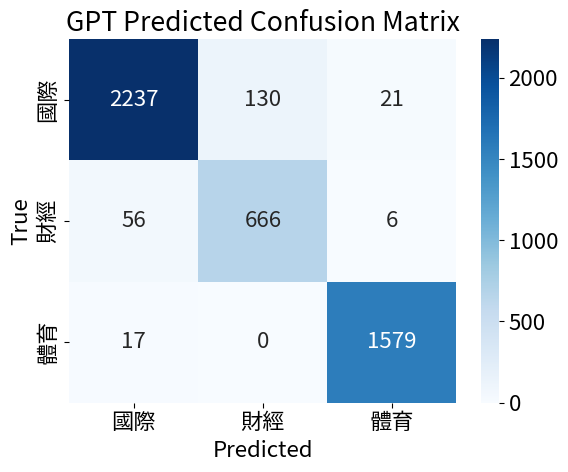

In [ ]:
# ‰ªç‰ΩøÁî®ÂâõÂâõÊ∏ÖÁêÜÈÅéÁöÑ df_eval
df_eval = ebc[['artCatagory', 'gpt_topic']].dropna()
df_eval = df_eval[df_eval['gpt_topic'] != "ÂÖ∂‰ªñ"]
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_topic'].astype(str)

# Ë®àÁÆóÊ∑∑Ê∑ÜÁü©Èô£
labels = sorted(list(set(y_true) | set(y_pred)))  # ÊâÄÊúâÂá∫ÁèæÈÅéÁöÑÈ°ûÂà•
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Áï´Âúñ
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GPT Predicted Confusion Matrix")
plt.tight_layout()
plt.show()

### ÈåØË™§È†êÊ∏¨ÂàÜÊûê  
Â∞á GPT ÂàÜÈ°ûÈåØË™§ÁöÑÊ®£Êú¨ÊâæÂá∫Ôºå‰∏¶ÈôÑ‰∏äÂÖ∂‰∏ªÈ°åÈóúÈçµË©ûÔºåÂπ´Âä©‰ΩøÁî®ËÄÖÁêÜËß£ GPT ÂèØËÉΩË™§Âà§ÁöÑË™ûÊÑèÂçÄÂ°ä„ÄÇ


In [ ]:
# Âª∫Á´ã‰∏ªÈ°åIDÂ∞çÊáâÁöÑÂâç10ÂÄãÈóúÈçµÂ≠óÂ≠ó‰∏≤ÔºàÁî®ÈÄóËôü‰∏≤Ëµ∑‰æÜÔºâ
topic_keywords_map = {
    topic_id: ", ".join([word for word, _ in zh_topic_model.get_topic(topic_id)[:10]])
    for topic_id in zh_topic_model.get_topics().keys()
    if topic_id != -1
}

# Êää‰∏ªÈ°åÈóúÈçµÂ≠óÊ¨Ñ‰ΩçÂä†Âà∞ ebc_raw Êàñ df_eval
df_eval['topic_keywords'] = ebc['topic'].map(topic_keywords_map)

# ÁØ©ÈÅ∏ÈåØË™§È†êÊ∏¨ÁöÑË≥áÊñô
df_misclassified = df_eval[df_eval['artCatagory'] != df_eval['gpt_topic']]

# È°ØÁ§∫ÈåØË™§Ê®£Êú¨ + ÊâÄÂ±¨‰∏ªÈ°åÈóúÈçµË©û
df_misclassified.head()



artCatagory gpt_topic                       topic_keywords
0           Ë≤°Á∂ì        ÂúãÈöõ  È∫µ, Â∫ó, ÂêÉ, ÊñôÁêÜ, ÂòâÁæ©, Âè∞ÁÅ£, Ê•≠ËÄÖ, È§êÂª≥, Êó•Êú¨, ÁôæË≤®
26          Ë≤°Á∂ì        ÂúãÈöõ  È∫µ, Â∫ó, ÂêÉ, ÊñôÁêÜ, ÂòâÁæ©, Âè∞ÁÅ£, Ê•≠ËÄÖ, È§êÂª≥, Êó•Êú¨, ÁôæË≤®
58          Ë≤°Á∂ì        ÂúãÈöõ  È∫µ, Â∫ó, ÂêÉ, ÊñôÁêÜ, ÂòâÁæ©, Âè∞ÁÅ£, Ê•≠ËÄÖ, È§êÂª≥, Êó•Êú¨, ÁôæË≤®
84          Ë≤°Á∂ì        ÂúãÈöõ  È∫µ, Â∫ó, ÂêÉ, ÊñôÁêÜ, ÂòâÁæ©, Âè∞ÁÅ£, Ê•≠ËÄÖ, È§êÂª≥, Êó•Êú¨, ÁôæË≤®
89          Ë≤°Á∂ì        ÂúãÈöõ  È∫µ, Â∫ó, ÂêÉ, ÊñôÁêÜ, ÂòâÁæ©, Âè∞ÁÅ£, Ê•≠ËÄÖ, È§êÂª≥, Êó•Êú¨, ÁôæË≤®

### Âª∫Á´ã KeyBERT Ë°®ÂæµÊ®°Âûã
‰ΩøÁî® KeyBERTInspired Âèñ‰ª£È†êË®≠ TF-IDFÔºåËÆìÊØèÂÄã‰∏ªÈ°åÁöÑ‰ª£Ë°®Ë©ûÊõ¥Âä†Ë™ûÊÑèÂ∞éÂêë„ÄÇ


In [ ]:
from bertopic.representation import KeyBERTInspired
# KeyBERT
keybert = KeyBERTInspired()

# Ë®≠ÂÆöHDBscanÊ®°Âûã
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=30)

# ÂÆöÁæ©ÊàëÂÄëË¶ÅÁî®Âà∞ÁöÑrepresentation modelÔºàÂêåÂ≠∏Â¶ÇÊûúÊÉ≥ÊØîËºÉÂÖ∂‰ªñÊ®°ÂûãÂèØ‰ª•Âú®ÈÄôÈÇäÂä†ÂÖ•ÂÖ∂‰ªñÊ®°ÂûãÊñπÊ≥ïÔºâ
representation_model = {
    "KeyBERT": keybert,
}

### ‰ΩøÁî® KeyBERT Âª∫Á´ãË™ûÊÑè‰∏ªÈ°åÊ®°Âûã
ÁµêÂêà BERT ÂêëÈáè„ÄÅjieba ÂàÜË©ûËàá KeyBERT Ë°®ÂæµÊ®°ÂûãÔºåÂª∫Á´ãË™ûÊÑèÂ∞éÂêëÁöÑ BERTopic ‰∏ªÈ°åÊ®°Âûã„ÄÇ


In [ ]:
# Âª∫Á´ãBERTopicÊ®°Âûã
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_ch,
  vectorizer_model=jieba_vectorizer,
  # Ë®≠ÂÆöRepresentation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  verbose=True,
  hdbscan_model=hdbscan_model,
)

# Train model
topics, probs = representation_topic_model.fit_transform(docs_zh, embeddings)

2025-05-10 08:55:49,825 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 08:55:57,099 - BERTopic - Dimensionality - Completed ‚úì
2025-05-10 08:55:57,100 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 08:55:57,217 - BERTopic - Cluster - Completed ‚úì
2025-05-10 08:55:57,222 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 08:56:19,748 - BERTopic - Representation - Completed ‚úì


In [ ]:
# ËßÄÂØüKeyBERTÂæÆË™øÂæåÁöÑ‰∏ªÈ°åË°®Á§∫
representation_topic_model.get_topic_info()

Topic  Count                Name  \
0      -1    605      -1_ÁæéÂúã_Êù±Ê£Æ_‰∏≠Âúã_ÂåóÈüì   
1       0   1626       0_‰∏≠ËèØÈöä_Âè∞ÁÅ£_Èô≥_Ê£íÁêÉ   
2       1   1293        1_‰∏ÄÂêç_Ê≠≤_Ë≠¶Êñπ_Áî∑Â≠ê   
3       2    208        2_‰ªÅÂã≥_ÈªÉ_ËºùÈÅî_ÊàøÂÉπ   
4       3    180      3_Â∑ùÊôÆ_Ë≥ÄÈå¶È∫ó_Á∏ΩÁµ±_ÁæéÂúã   
5       4    148       4_Ëà™Á©∫_È£õÊ©ü_‰∫ãÊïÖ_Ê©üÂ†¥   
6       5    144       5_Âú∞Èúá_Â§ßÈõ™_Ê∞ëÁúæ_Á©çÈõ™   
7       6    133      6_Â∞πÈå´ÊÇÖ_ÊàíÂö¥_ÂçóÈüì_Á∏ΩÁµ±   
8       7    122       7_Á∂≤Âèã_Âè∞ËÇ°_ËÇ°ÂÉπ_ÊäïË≥á   
9       8    115        8_Êó©Áõ§_‰æÜÂà∞_ÂÖÉÊº≤_ÂÖÉ   
10      9    113       9_Êº≤ÂπÖ_Êî∂ÂÖÉ_Êº≤ÂÖÉ_ÊóèÁæ§   
11     10    112      10_ÁæéÂúã_ÈóúÁ®Ö_Â∑ùÊôÆ_‰∏≠Âúã   
12     11     83  11_‰ª•Ëâ≤Âàó_ÈªéÂ∑¥Â´©_Áúü‰∏ªÈª®_ÊïòÂà©‰∫û   
13     12     72   12_ÁÉèÂÖãËò≠_‰øÑÁæÖÊñØ_ÂÄ´ÊñØÂü∫_Á∏ΩÁµ±   
14     13     64     13_‰∏≠Âúã_Ëß£ÊîæËªç_Êà∞Ê©ü_ËªçÊºî   
15     14     50      14_Ë£ÅÂì°_Âì°Â∑•_ÂÖ¨Âè∏_Êó•Áî¢   
16     15     50       15_Áî≥Ë≥º_ÂÖÉ_ÊâøÈä∑_Âè∞ËÇ°   
17     16     41    16_Êô∂Áâá_ÊäÄË°ì_Âè∞Á©çÈõª_ÂçäÂ∞éÈ´î   
18     17     32        17_Êñ∞ÂÖâ_Èáë_‰∏≠‰ø°_‰Ωµ   
19     18     32    18_ÂëºÂè´Âô®_ÈòøÊ≥¢ÁæÖ_ÂÖ¨Âè∏_ÁàÜÁÇ∏   
20     19     22     19_ËºùÈÅî_‰∏≠Âúã_ÂÖ¨Âè∏_ÂÑÑÁæéÂÖÉ   

                                       Representation  \
0   [ÁæéÂúã, Êù±Ê£Æ, ‰∏≠Âúã, ÂåóÈüì, Êñ∞ËÅû, Â∏ÇÂ†¥,  , ÂÖ¨Âè∏, Êô∂Áâá, Âè∞ÁÅ£, Â∑ùÊôÆ, ÊäïË≥á...   
1   [‰∏≠ËèØÈöä, Âè∞ÁÅ£, Èô≥, Ê£íÁêÉ, ÊäïÊâã, ÁêÉËø∑, ‰∏ñÁïå, Ë≥Ω, ÊØîË≥Ω, Á∂ìÂÖ∏, ÁêÉÂì°, Êó•Êú¨...   
2   [‰∏ÄÂêç, Ê≠≤, Ë≠¶Êñπ, Áî∑Â≠ê, ÁôºÁîü, ÁôºÁèæ, Êñ∞ËÅû, Â•≥Â≠ê,  , ‰∏≠, Êù±Ê£Æ, ‰∫ã‰ª∂, ...   
3   [‰ªÅÂã≥, ÈªÉ, ËºùÈÅî, ÊàøÂÉπ, Ëê¨, Ë≤∏Ê¨æ, Êù±Ê£Æ, Â§ßÂ∞è‰∫ã, Ëê¨ÂÖÉ, Âü∑Ë°åÈï∑, Â§ÆË°å, Ê∞ë...   
4   [Â∑ùÊôÆ, Ë≥ÄÈå¶È∫ó, Á∏ΩÁµ±, ÁæéÂúã, ÂÄôÈÅ∏‰∫∫, Â∑û, ÊãúÁôª, ÊäïÁ•®, ÈÅ∏Ê∞ë, Ê∞ë‰∏ªÈª®, ËæØË´ñ,...   
5   [Ëà™Á©∫, È£õÊ©ü, ‰∫ãÊïÖ, Ê©üÂ†¥, ÂÆ¢Ê©ü, Á©∫Èõ£, ÊøüÂ∑û, ÈôçËêΩ, ‰πòÂÆ¢, Áè≠Ê©ü, ‰∏ÄÊû∂, Ëà™...   
6   [Âú∞Èúá, Â§ßÈõ™, Ê∞ëÁúæ, Á©çÈõ™, Êó•Êú¨, È¢±È¢®, Âú∞ÂçÄ, ÁôºÁîü, ÂΩ±Èüø, Èôç‰∏ã, Ê¥™Ê∞¥, ÂÖ¨...   
7   [Â∞πÈå´ÊÇÖ, ÊàíÂö¥, ÂçóÈüì, Á∏ΩÁµ±, ÂúãÊúÉ, ÂΩàÂäæ, ÂΩàÂäæÊ°à, Âü∑ÊîøÈª®, ÂúãÊ∞ë, Âú®ÈáéÈª®, Ë≠∞...   
8   [Á∂≤Âèã, Âè∞ËÇ°, ËÇ°ÂÉπ, ÊäïË≥á, Êù±Ê£Æ, Ë≤∑, Ë≤°Á∂ì, ÊäïË≥á‰∫∫, ËÇ°Á•®, ÁãÑÈ©§, Â∏ÇÂ†¥, ËÇ°...   
9   [Êó©Áõ§, ‰æÜÂà∞, ÂÖÉÊº≤, ÂÖÉ, Êº≤ÂπÖ, ÈÄæ, ÊóèÁæ§, Âè∞ËÇ°, ËÇ°, ÈúáÁõ™, ÊúÄ‰Ωé, ‰∏ãÊé¢, ...   
10  [Êº≤ÂπÖ, Êî∂ÂÖÉ, Êº≤ÂÖÉ, ÊóèÁæ§, Âè∞ËÇ°, ‰ΩúÊî∂, ÂÖÉ, Êº≤ÂÅú, Ë∑åÂπÖ, Êî∂Êº≤, ÁµÇÂ†¥, ‰ª•Èªû...   
11  [ÁæéÂúã, ÈóúÁ®Ö, Â∑ùÊôÆ, ‰∏≠Âúã, Âè∞ÁÅ£, Á∏ΩÁµ±, Âä†ÊãøÂ§ß, ÂúãÂÆ∂, Êô∂Áâá, ÁøíËøëÂπ≥, ÊîøÁ≠ñ,...   
12  [‰ª•Ëâ≤Âàó, ÈªéÂ∑¥Â´©, Áúü‰∏ªÈª®, ÊïòÂà©‰∫û, ‰ª•Ëªç, Á©∫Ë•≤, ‰ºäÊúó, ÊîªÊìä, Âä†Ëñ©, Â°ûÂæ∑, Âìà...   
13  [ÁÉèÂÖãËò≠, ‰øÑÁæÖÊñØ, ÂÄ´ÊñØÂü∫, Á∏ΩÁµ±, ÊôÆ‰∏Å, Êæ§, Êà∞Áà≠, ÁæéÂúã, Â∑ùÊôÆ, ÂåóÈüì, ÂçîË≠∞,...   
14  [‰∏≠Âúã, Ëß£ÊîæËªç, Êà∞Ê©ü, ËªçÊºî, Âè∞ÁÅ£, ÁæéÂúã, ÂúãÈò≤ÈÉ®, ÊºîÁøí, Âà©Âäç, Ëªç‰∫ã, ÂÖ±Ëªç,...   
15  [Ë£ÅÂì°, Âì°Â∑•, ÂÖ¨Âè∏, Êó•Áî¢, Êú¨Áî∞, Ê±ΩËªä, Â∏ÇÂ†¥, Ê•≠Âãô, Ë®àÂäÉ, Á¥Ñ, ÂÖ®ÁêÉ, Á†¥Áî¢...   
16  [Áî≥Ë≥º, ÂÖÉ, ÊâøÈä∑, Âè∞ËÇ°, ÊØèËÇ°, ‰∫§Ââ≤, Êù±Ê£Æ, ÂÑÑÂÖÉ, ÊäïË≥á‰∫∫, ËÇ°ÂÉπ, ÊäΩÁ±§, ‰ªä...   
17  [Êô∂Áâá, ÊäÄË°ì, Âè∞Á©çÈõª, ÂçäÂ∞éÈ´î, Ë£ΩÁ®ã, Áü≥Â¢®, ÁÉØ, ÁæéÂúã, Ëã±ÁâπÁàæ, Âè∞Á©ç, ËºùÈÅî,...   
18  [Êñ∞ÂÖâ, Èáë, ‰∏≠‰ø°, ‰Ωµ, ÈáëÁÆ°ÊúÉ, ÈáëÊéß, Êî∂Ë≥º, Âê≥Êù±‰∫Æ, Âè∞Êñ∞Èáë, ‰ΩµË≥º, ËÇ°Êù±, ...   
19  [ÂëºÂè´Âô®, ÈòøÊ≥¢ÁæÖ, ÂÖ¨Âè∏, ÁàÜÁÇ∏, ÈªéÂ∑¥Â´©, Èáë, ‰ª•Ëâ≤Âàó, Âè∞ÁÅ£, Ë£ΩÈÄ†, ÁÇ∏Ëó•, Ëë£‰∫ã...   
20  [ËºùÈÅî, ‰∏≠Âúã, ÂÖ¨Âè∏, ÂÑÑÁæéÂÖÉ, Âì°Â∑•, ‰ªÅÂã≥, Êô∂Áâá, ÈªÉ, Ë≤°ÂØå, ÊØîÁâπ, ËÇ°ÂÉπ, È¶ñ...   

                                              KeyBERT  \
0   [ÂçäÂ∞éÈ´î, Âè∞Á©çÈõª, Ëã±ÁâπÁàæ, Ê∂àË≤ªËÄÖ, ÊäïË≥á‰∫∫, È¶¨ÊñØÂÖã, ‰øÑÁæÖÊñØ, ‰∏≠Â§ÆÁ§æ, Êô∂Áâá, ÂÑÑÁæéÂÖÉ]   
1   [ÂßîÂÖßÁëûÊãâ, Â§öÊòéÂ∞ºÂä†, Â∞ºÂä†ÊãâÁìú, Ë≥áÊ†ºË≥Ω, Êó•Êú¨Èöä, ÂÖ®Â£òÊâì, Âè∞ÁÅ£Èöä, ‰∏≠ËèØÈöä, ÊäïÊâã...   
2          [Ê∂àË≤ªËÄÖ, Ê≤íÊÉ≥Âà∞, ÈóúÊ≥®, ÈÄôÂêç, ÈÄÆÊçï, Âø´‰æÜ, ÈÄèÈú≤, ÈÄ±Âàä, Áï´Èù¢, ËÜ†Âéü]   
3        [Âè∞Á©çÈõª, Ëë£‰∫ãÈï∑, Âü∑Ë°åÈï∑, ÊàøÂ≠ê, Â∞àÂÆ∂, Âø´‰æÜ, ÂúüÂú∞, ÂòâÁæ©, ÂÆπÁ©çÁéá, Â§ÆË°å]   
4   [ÁæéÂúãÊ∞ë‰∏ªÈª®, ÁæéÂúãÂÖ±ÂíåÈª®, Â®ÅÊñØ

In [ ]:
representation_topic_model.visualize_topics()

### Êì∑Âèñ KeyBERT ‰∏ªÈ°åË©û‰∏¶ÂÇ≥ÂÖ• GPT
‰ΩøÁî® representation_topic_model ‰∏≠ÊØèÂÄã‰∏ªÈ°åÁöÑ KeyBERT Ë©ûÂΩô‰ΩúÁÇ∫Ë™ûÊÑèË©ÆÈáãËº∏ÂÖ•ÔºåËÆì GPT Áµ¶Âá∫‰∏ªÈ°åÂàÜÈ°û„ÄÇ


In [ ]:
# Êì∑Âèñ representation_topic_model.get_topic_info() ‰∏≠ÁöÑ KeyBERT Ë©ÆÈáãË©û
topic_info_df = representation_topic_model.get_topic_info()

# Âª∫Á´ã‰∏ªÈ°åÂ∞çÊáâÈóúÈçµË©ûÂ≠óÂÖ∏ÔºàÁî® KeyBERT Ë©ÆÈáãÁöÑ‰ª£Ë°®Ë©ûÔºåÈÄóËôüÂàÜÈöîÔºâ
rep_topic_keywords_for_gpt = {
    row['Topic']: row['KeyBERT']
    for _, row in topic_info_df.iterrows()
    if row['Topic'] != -1
}

In [ ]:
# Âü∑Ë°å GPT Ë©ÆÈáãÔºà‰ΩøÁî® KeyBERT Ë©ûÔºâ
gpt_labels_rep = {}
for topic_id, keywords in tqdm(rep_topic_keywords_for_gpt.items(), desc="GPT Ë©ÆÈáã representation ‰∏ªÈ°å‰∏≠"):
    label = call_gpt(keywords)
    gpt_labels_rep[topic_id] = label
    time.sleep(1.5)

# Â∞çÊáâÂõûÊñáÁ´†Ë≥áÊñô
ebc['rep_topic'] = representation_topic_model.get_document_info(docs_zh)['Topic']
ebc['gpt_rep_topic'] = ebc['rep_topic'].map(gpt_labels_rep)

GPT Ë©ÆÈáã representation ‰∏ªÈ°å‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:37<00:00,  1.90s/it]


In [ ]:
ebc['gpt_rep_topic'].value_counts()

gpt_rep_topic
ÂúãÈöõ    1740
È´îËÇ≤    1399
Ë≤°Á∂ì     698
Name: count, dtype: int64

In [ ]:
df_eval = ebc[['artCatagory', 'gpt_rep_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_rep_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          ÂúãÈöõ       0.84      0.95      0.89      1551
          Ë≤°Á∂ì       0.89      0.89      0.89       700
          È´îËÇ≤       0.95      0.84      0.89      1586

    accuracy                           0.89      3837
   macro avg       0.90      0.89      0.89      3837
weighted avg       0.90      0.89      0.89      3837



### ÁµêÂêà KeyBERT Ëàá MMR ÁöÑ‰∏ªÈ°åË°®Á§∫
MMR ÂèØÊ∏õÂ∞ëË©ûÂΩôÈáçË§á„ÄÅÊèêÂçáÂ§öÊ®£ÊÄßÔºõËàá KeyBERT Êê≠ÈÖçËÉΩÂπ≥Ë°°Ë™ûÊÑè‰∏≠ÂøÉËàáË≥áË®äË¶ÜËìã„ÄÇ


In [ ]:
# Step 1ÔºöÂª∫Á´ã‰∏ªÈ°åIDÂ∞çÊáâÁöÑ KeyBERT Ë™ûÊÑèÈóúÈçµË©ûÔºàÂ≠ó‰∏≤Ê†ºÂºèÔºâ
rep_topic_info_df = representation_topic_model.get_topic_info()
rep_topic_keywords_map = {
    row['Topic']: row['KeyBERT']
    for _, row in rep_topic_info_df.iterrows()
    if row['Topic'] != -1
}

# Step 2ÔºöÂª∫Á´ãË≥áÊñôÈõÜÔºàÂåÖÂê´ contentÔºâ
df_eval_rep = ebc[['content', 'artCatagory', 'rep_topic', 'gpt_rep_topic']].dropna()
df_eval_rep['topic_keywords'] = df_eval_rep['rep_topic'].map(rep_topic_keywords_map)

# Step 3ÔºöÁØ©ÈÅ∏ GPT È†êÊ∏¨ÈåØË™§ÁöÑÊ®£Êú¨
df_misclassified_rep = df_eval_rep[
    df_eval_rep['artCatagory'].astype(str) != df_eval_rep['gpt_rep_topic'].astype(str)
]

# Step 4ÔºöÈ°ØÁ§∫ÈåØË™§Ê®£Êú¨ÔºàÂåÖÂê´ contentÔºâ
df_misclassified_rep[['content', 'artCatagory', 'gpt_rep_topic', 'topic_keywords']].head()


content artCatagory  \
69   ÈáéÁîüÊçïÊçâÁµêÊùüÁôΩÂÆÆÊúÉË≠∞ÈªÉ‰ªÅÂã≥Êö¢Ë´áÊú™‰æÜÂ∏ÉÂ±ÄÁæéÂúãÁôΩÂÆÆÂè¨ÈõÜ‰∫ÜÁßëÊäÄ‰∏ÉÂ∑®È†≠ÁöÑÈ´òÂ±§ÈáùÂ∞çÂíåËÉΩÊ∫êË≠∞È°åÊ¥ΩË´áÁï∂ÊôÇËºù...          Ë≤°Á∂ì   
91   ÂçÉÂÑÑË±™ÈñÄÂ©öÂßªÁ†¥ÊªÖÊûóÈ¥ªÂçóÁéãÂ©âÁé≤Ë¶™Êè≠Â©öËÆäÂÖßÂπïÂçÉÂÑÑË±™ÈñÄÂ©öÂßªÁ†¥ÊªÖÊ©´Ë∑®ÈáëËûçÂª∫Ë®≠Áî¢Ê•≠ÁöÑÂçÉÂÑÑÂÆèÊ≥∞ÈõÜÂúòÊéåÈñÄ‰∫∫...          Ë≤°Á∂ì   
133  ÊìÅÂºµÂè∞Á©çÈõª‰ªçÂö¥ÂÆàÁ¥ÄÂæã‰ªñÂÄëÈõ®Â§©ÂØßÈ®é‰πü‰∏çÊê≠Â∞èÈªÉÂ¶ÇÊûú‰Ω†ÊòØÂçÉËê¨Ë∫´ÂÉπÁöÑÂØåÁøÅÂ¶ÇÊûúÊ≤íÊúâÊç∑ÈÅãÂèØÊê≠‰Ω†ÊúÉÈÅ∏ÊìáÂè´Â∞è...          Ë≤°Á∂ì   
181  È¨ºÊïÖ‰∫ãÂèà‰æÜ‰∫ÜÂ§ñË≥áÊ∑®Á©∫ÂñÆËøëËê¨Âè£Â∞àÂÆ∂Âã∏Ë¶ÅÂ∞äÈáçÂè∞ËÇ°‰ªäÊó•Êî∂Êº≤Èªû‰ª•Èªû‰ΩúÊî∂Áõ§ÂæåÂÖ¨Â∏É‰∏âÂ§ßÊ≥ï‰∫∫Ë≤∑Ë≥£Ë∂Ö‰∏âÂ§ßÊ≥ï‰∫∫...          Ë≤°Á∂ì   
184  Âπ¥Ëñ™Ë≤∑Ëê¨È†êÂîÆÂ±ã‰ªñË¶ã‰∏ÄÂ†Ü‰∫∫Ë≤∏Ê¨æÊ≤íÈÅéÂöáÂÇªÊúâ‰∫õ‰∫∫Âä™ÂäõÂ≠òÈå¢Âè™ÁÇ∫‰∫ÜÊÉ≥Ë¶ÅÊìÅÊúâ‰∏ÄÈñìÂ±¨ÊñºËá™Â∑±ÁöÑÊàøÂ≠ê‰∏çÈÅéËæõËæõËã¶...          Ë≤°Á∂ì   

    gpt_rep_topic                                     topic_keywords  
69             ÂúãÈöõ  [Â∑¥ÊãøÈ¶¨ÈÅãÊ≤≥, ËÅØÂêàÂúã, Ë°åÊîøÂëΩ‰ª§, ÁøíËøëÂπ≥, ÂçäÂ∞éÈ´î, Âä†ÊãøÂ§ß, Â¢®Ë•øÂì•, Ê∂àË≤ªËÄÖ, Â∑¥Êãø...  
91             ÂúãÈöõ         [Ê∂àË≤ªËÄÖ, Ê≤íÊÉ≥Âà∞, ÈóúÊ≥®, ÈÄôÂêç, ÈÄÆÊçï, Âø´‰æÜ, ÈÄèÈú≤, ÈÄ±Âàä, Áï´Èù¢, ËÜ†Âéü]  
133            ÂúãÈöõ  [ÁæéÂúãÂúãÈò≤ÈÉ®, ÁøíËøëÂπ≥, ÂúãÈò≤ÈÉ®, ÁÑ°‰∫∫Ê©ü, Ëè≤ÂæãË≥ì, ÁôºË®Ä‰∫∫, ÈáëËûçÊôÇÂ†±, Ë≥¥Ê∏ÖÂæ∑, ÈóúÊ≥®...  
181            ÂúãÈöõ       [ÂÜ∑Á©∫Ê∞£, ÂåóÊµ∑ÈÅì, Ê∞£Ë±°Âª≥, ÈæçÊç≤È¢®, Ëøé‰æÜ, Âø´‰æÜ, ÊåÅÁ∫å, Ê∑πÊ∞¥, Ëá≥Â∞ë, ËªäËºõ]  
184            ÂúãÈöõ       [ÂÜ∑Á©∫Ê∞£, ÂåóÊµ∑ÈÅì, Ê∞£Ë±°Âª≥, ÈæçÊç≤È¢®, Ëøé‰æÜ, Âø´‰æÜ, ÊåÅÁ∫å, Ê∑πÊ∞¥, Ëá≥Â∞ë, ËªäËºõ]

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

# ÂÆöÁæ©ÂÖ©ÂÄã representation model
keybert = KeyBERTInspired()
mmr = MaximalMarginalRelevance(diversity=0.3)

# Âª∫Á´ãÊ∑∑ÂêàÂºè representation Ê®°ÂûãÔºàKeyBERT + MMRÔºâ
representation_model = {
    "KeyBERT": keybert,
    "MMR": mmr
}

# Âª∫Á´ã BERTopic Ê®°ÂûãÔºà‰ΩøÁî® representation modelÔºâ
mixed_rep_topic_model = BERTopic(
    embedding_model=bert_ch,
    vectorizer_model=jieba_vectorizer,
    representation_model=representation_model,
    hdbscan_model=hdbscan_model,
    top_n_words=30,
    verbose=True
)

# Âü∑Ë°å‰∏ªÈ°åÂª∫Ê®°
topics, probs = mixed_rep_topic_model.fit_transform(docs_zh, embeddings)


2025-05-10 09:00:35,204 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-10 09:00:47,423 - BERTopic - Dimensionality - Completed ‚úì
2025-05-10 09:00:47,435 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-10 09:00:47,662 - BERTopic - Cluster - Completed ‚úì
2025-05-10 09:00:47,667 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-10 09:01:14,592 - BERTopic - Representation - Completed ‚úì


In [ ]:
mixed_rep_topic_model.get_topic_info()

Topic  Count                Name  \
0      -1    665      -1_ÁæéÂúã_Êù±Ê£Æ_ÂÖ¨Âè∏_‰∏≠Âúã   
1       0   1622       0_‰∏≠ËèØÈöä_Âè∞ÁÅ£_Èô≥_Ê£íÁêÉ   
2       1   1272        1_‰∏ÄÂêç_Ê≠≤_Ë≠¶Êñπ_Áî∑Â≠ê   
3       2    196        2_‰ªÅÂã≥_ÈªÉ_ËºùÈÅî_ÊàøÂÉπ   
4       3    177      3_Â∑ùÊôÆ_Ë≥ÄÈå¶È∫ó_Á∏ΩÁµ±_ÁæéÂúã   
5       4    149       4_Ëà™Á©∫_È£õÊ©ü_‰∫ãÊïÖ_Ê©üÂ†¥   
6       5    142       5_Âú∞Èúá_Â§ßÈõ™_Á©çÈõ™_Ê∞ëÁúæ   
7       6    141      6_Â∞πÈå´ÊÇÖ_ÊàíÂö¥_ÂçóÈüì_Á∏ΩÁµ±   
8       7    131       7_Á∂≤Âèã_Âè∞ËÇ°_ËÇ°ÂÉπ_ÊäïË≥á   
9       8    116       8_ÁæéÂúã_‰∏≠Âúã_ÈóúÁ®Ö_Â∑ùÊôÆ   
10      9    114       9_Êº≤ÂπÖ_Êî∂ÂÖÉ_Êº≤ÂÖÉ_ÊóèÁæ§   
11     10    113       10_Êó©Áõ§_‰æÜÂà∞_ÂÖÉÊº≤_ÂÖÉ   
12     11     83  11_‰ª•Ëâ≤Âàó_ÈªéÂ∑¥Â´©_Áúü‰∏ªÈª®_ÊïòÂà©‰∫û   
13     12     65   12_ÁÉèÂÖãËò≠_‰øÑÁæÖÊñØ_ÂÄ´ÊñØÂü∫_Á∏ΩÁµ±   
14     13     64     13_‰∏≠Âúã_Ëß£ÊîæËªç_Êà∞Ê©ü_Âè∞ÁÅ£   
15     14     58       14_Áî≥Ë≥º_ÂÖÉ_ÊâøÈä∑_ÊØèËÇ°   
16     15     46      15_Ë£ÅÂì°_Âì°Â∑•_ÂÖ¨Âè∏_Êó•Áî¢   
17     16     31        16_Êñ∞ÂÖâ_Èáë_‰∏≠‰ø°_‰Ωµ   
18     17     30     17_Êô∂Áâá_Áü≥Â¢®_ÂçäÂ∞éÈ´î_Ë£ΩÁ®ã   
19     18     18    18_ÁàÜÁÇ∏_ÂëºÂè´Âô®_ÈªéÂ∑¥Â´©_ÂÖ¨Âè∏   
20     19     12     19_È¶ñÂØå_Ë≤°ÂØå_ËºùÈÅî_ÂÑÑÁæéÂÖÉ   

                                       Representation  \
0   [ÁæéÂúã, Êù±Ê£Æ, ÂÖ¨Âè∏, ‰∏≠Âúã, Êñ∞ËÅû,  , ÂåóÈüì, Â∏ÇÂ†¥, Âè∞ÁÅ£, Â∑ùÊôÆ, Êô∂Áâá, ‰∏≠,...   
1   [‰∏≠ËèØÈöä, Âè∞ÁÅ£, Èô≥, Ê£íÁêÉ, ÊäïÊâã, ÁêÉËø∑, ‰∏ñÁïå, Ë≥Ω, ÊØîË≥Ω, Á∂ìÂÖ∏, ÁêÉÂì°, Êó•Êú¨...   
2   [‰∏ÄÂêç, Ê≠≤, Ë≠¶Êñπ, Áî∑Â≠ê, ÁôºÁîü, ÁôºÁèæ, Â•≥Â≠ê, Êñ∞ËÅû,  , ‰∏≠, Êù±Ê£Æ, ‰∫ã‰ª∂, ...   
3   [‰ªÅÂã≥, ÈªÉ, ËºùÈÅî, ÊàøÂÉπ, Ëê¨, Ë≤∏Ê¨æ, Êù±Ê£Æ, Â§ÆË°å, Â§ßÂ∞è‰∫ã, Âü∑Ë°åÈï∑, Ë™™, Ë≤∑,...   
4   [Â∑ùÊôÆ, Ë≥ÄÈå¶È∫ó, Á∏ΩÁµ±, ÁæéÂúã, ÂÄôÈÅ∏‰∫∫, Â∑û, ÊäïÁ•®, ÈÅ∏Ê∞ë, Ê∞ë‰∏ªÈª®, ÊãúÁôª, ËæØË´ñ,...   
5   [Ëà™Á©∫, È£õÊ©ü, ‰∫ãÊïÖ, Ê©üÂ†¥, ÂÆ¢Ê©ü, Á©∫Èõ£, ÊøüÂ∑û, ÈôçËêΩ, ‰πòÂÆ¢, Áè≠Ê©ü, ‰∏ÄÊû∂, Ëà™...   
6   [Âú∞Èúá, Â§ßÈõ™, Á©çÈõ™, Ê∞ëÁúæ, Êó•Êú¨, Âú∞ÂçÄ, È¢±È¢®, ÁôºÁîü, ÂΩ±Èüø, Èôç‰∏ã, Ê¥™Ê∞¥, ÂÖ¨...   
7   [Â∞πÈå´ÊÇÖ, ÊàíÂö¥, ÂçóÈüì, Á∏ΩÁµ±, ÂúãÊúÉ, ÂΩàÂäæ, ÂΩàÂäæÊ°à, Âü∑ÊîøÈª®, ÂúãÊ∞ë, Âú®ÈáéÈª®, Ë≠∞...   
8   [Á∂≤Âèã, Âè∞ËÇ°, ËÇ°ÂÉπ, ÊäïË≥á, Êù±Ê£Æ, Ë≤∑, ÊäïË≥á‰∫∫, Â∏ÇÂ†¥, Ë≤°Á∂ì, ÁãÑÈ©§, ËÇ°Â∏Ç, ËÇ°...   
9   [ÁæéÂúã, ‰∏≠Âúã, ÈóúÁ®Ö, Â∑ùÊôÆ, Âè∞ÁÅ£, Á∏ΩÁµ±, Êô∂Áâá, Âä†ÊãøÂ§ß, ÂúãÂÆ∂, ÁøíËøëÂπ≥, Á∂ìÊøü,...   
10  [Êº≤ÂπÖ, Êî∂ÂÖÉ, Êº≤ÂÖÉ, ÊóèÁæ§, Âè∞ËÇ°, ‰ΩúÊî∂, ÂÖÉ, Êº≤ÂÅú, Ë∑åÂπÖ, Êî∂Êº≤, ÁµÇÂ†¥, ‰ª•Èªû...   
11  [Êó©Áõ§, ‰æÜÂà∞, ÂÖÉÊº≤, ÂÖÉ, Êº≤ÂπÖ, ÈÄæ, ÊóèÁæ§, Âè∞ËÇ°, ËÇ°, ÈúáÁõ™, ÊúÄ‰Ωé, ‰∏ãÊé¢, ...   
12  [‰ª•Ëâ≤Âàó, ÈªéÂ∑¥Â´©, Áúü‰∏ªÈª®, ÊïòÂà©‰∫û, ‰ª•Ëªç, Á©∫Ë•≤, ‰ºäÊúó, ÊîªÊìä, Âä†Ëñ©, Â°ûÂæ∑, Âìà...   
13  [ÁÉèÂÖãËò≠, ‰øÑÁæÖÊñØ, ÂÄ´ÊñØÂü∫, Á∏ΩÁµ±, Êà∞Áà≠, Êæ§, ÊôÆ‰∏Å, ÁæéÂúã, Â∑ùÊôÆ, ÂçîË≠∞, ‰øÑÁÉè,...   
14  [‰∏≠Âúã, Ëß£ÊîæËªç, Êà∞Ê©ü, Âè∞ÁÅ£, ËªçÊºî, ÁæéÂúã, ÂúãÈò≤ÈÉ®, ÊºîÁøí, Âà©Âäç, Ëªç‰∫ã, ÂÖ±Ëªç,...   
15  [Áî≥Ë≥º, ÂÖÉ, ÊâøÈä∑, ÊØèËÇ°, Êù±Ê£Æ, Âè∞ËÇ°, ‰∫§Ââ≤, ÊäΩÁ±§, Ë≥∫, ËÇ°ÂÉπ, ÂÑÑÂÖÉ, ‰∫§Êòì,...   
16  [Ë£ÅÂì°, Âì°Â∑•, ÂÖ¨Âè∏, Êó•Áî¢, Êú¨Áî∞, Ê±ΩËªä, Ê•≠Âãô, Â∏ÇÂ†¥, Ë®àÂäÉ, ÂÖ®ÁêÉ, Á¥Ñ, ÈäÄÊ≥∞...   
17  [Êñ∞ÂÖâ, Èáë, ‰∏≠‰ø°, ‰Ωµ, ÈáëÁÆ°ÊúÉ, ÈáëÊéß, Êî∂Ë≥º, Âê≥Êù±‰∫Æ, Âè∞Êñ∞Èáë, ‰ΩµË≥º, ÂÖ¨Âè∏, ...   
18  [Êô∂Áâá, Áü≥Â¢®, ÂçäÂ∞éÈ´î, Ë£ΩÁ®ã, Âè∞Á©çÈõª, ÁÉØ, ÊäÄË°ì, ÁæéÂúã, Âè∞Á©ç, ÁßëÊäÄ, ËÅØÈõª, ...   
19  [ÁàÜÁÇ∏, ÂëºÂè´Âô®, ÈªéÂ∑¥Â´©, ÂÖ¨Âè∏, ‰ª•Ëâ≤Âàó, ÁÇ∏Ëó•, ÈòøÊ≥¢ÁæÖ, Âè∞ÁÅ£, ÂºïÁàÜ, ÂåàÁâôÂà©, ...   
20  [È¶ñÂØå, Ë≤°ÂØå, ËºùÈÅî, ÂÑÑÁæéÂÖÉ, ÂÑÑËê¨ÂØåË±™, ‰∏≠Âúã, ÂÆ∂Êóè, ÂÖ®ÁêÉ, ‰ªÅÂã≥, ÈªÉ, ÂÖ¨Âè∏,...   

                                              KeyBERT  \
0    [ÂçäÂ∞éÈ´î, Âè∞Á©çÈõª, Ëã±ÁâπÁàæ, Ê∂àË≤ªËÄÖ, Ëë£‰∫ãÈï∑, Âü∑Ë°åÈï∑, ÈóúÊ≥®, ÁÑ°‰∫∫Ê©ü, ‰øÑÁæÖÊñØ, Êô∂Áâá]   
1   [ÂßîÂÖßÁëûÊãâ, Â§öÊòéÂ∞ºÂä†, Â∞ºÂä†ÊãâÁìú, Ë≥áÊ†ºË≥Ω, Êó•Êú¨Èöä, ÂÖ®Â£òÊâì, Âè∞ÁÅ£Èöä, ‰∏≠ËèØÈöä, ÊäïÊâã...   
2          [Ê∂àË≤ªËÄÖ, Ê≤íÊÉ≥Âà∞, ÈóúÊ≥®, ÈÄôÂêç, ÈÄÆÊçï, Âø´‰æÜ, ÈÄèÈú≤, Áï´Èù¢, ÈÄ±Âàä, ËÜ†Âéü]   
3        [Âè∞Á©çÈõª, Ëë£‰∫ãÈï∑, Âü∑Ë°åÈï∑, ÊàøÂ≠ê, Â∞àÂÆ∂, Âø´‰æÜ, ÂúüÂú∞, ÂòâÁæ©, ÂÆπÁ©çÁéá, Â§ÆË°å]   
4   [ÁæéÂúãÊ∞ë‰∏ªÈª®, ÁæéÂúãÂÖ±ÂíåÈª®, Â®ÅÊñØÂ∫∑Ëæõ, Ê∞

In [ ]:
topic_info = mixed_rep_topic_model.get_topic_info()
topic_keywords_for_gpt = {
    row['Topic']: row['MMR']
    for _, row in topic_info.iterrows()
    if row['Topic'] != -1
}


In [ ]:
# Âü∑Ë°å GPT Ë©ÆÈáãÔºà‰ΩøÁî® KeyBERT Ë©ûÔºâ
gpt_labels_rep = {}
for topic_id, keywords in tqdm(topic_keywords_for_gpt.items(), desc="GPT Ë©ÆÈáã MMR ‰∏ªÈ°å‰∏≠"):
    label = call_gpt(keywords)
    gpt_labels_rep[topic_id] = label
    time.sleep(1.5)

# Â∞çÊáâÂõûÊñáÁ´†Ë≥áÊñô
ebc['MMR_topic'] = mixed_rep_topic_model.get_document_info(docs_zh)['Topic']
ebc['gpt_MMR_topic'] = ebc['rep_topic'].map(gpt_labels_rep)

GPT Ë©ÆÈáã MMR ‰∏ªÈ°å‰∏≠: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:37<00:00,  1.88s/it]


In [ ]:
df_eval = ebc[['artCatagory', 'gpt_MMR_topic']].dropna()
y_true = df_eval['artCatagory'].astype(str)
y_pred = df_eval['gpt_MMR_topic'].astype(str)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          ÂúãÈöõ       0.79      0.90      0.84      1551
          Ë≤°Á∂ì       0.77      0.74      0.76       700
          È´îËÇ≤       0.95      0.84      0.89      1586

    accuracy                           0.85      3837
   macro avg       0.84      0.83      0.83      3837
weighted avg       0.85      0.85      0.85      3837



### ‰∏çÂêå‰∏ªÈ°åË°®Á§∫ÊñπÂºèÁöÑÂàÜÈ°ûÊïàËÉΩÊØîËºÉ
Êú¨Ë°®ÊØîËºÉ TF-IDF„ÄÅKeyBERT„ÄÅMMR ‰∏âÁ®Æ‰∏ªÈ°åÈóúÈçµË©ûÂ∞ç GPT Ë©ÆÈáãÊ∫ñÁ¢∫ÊÄßÁöÑÂΩ±Èüø„ÄÇ


In [ ]:

# Âª∫Á´ãÂ†±Âëä
report1 = classification_report(df1['artCatagory'], df1['gpt_topic'], output_dict=True)
report2 = classification_report(df2['artCatagory'], df2['gpt_rep_topic'], output_dict=True)
report3 = classification_report(df3['artCatagory'], df3['gpt_MMR_topic'], output_dict=True)

# Âèñ weighted avg ÁöÑ precision/recall/f1-score
summary_df = pd.DataFrame({
    "TF-IDF": {
        "Precision": report1["weighted avg"]["precision"],
        "Recall": report1["weighted avg"]["recall"],
        "F1-score": report1["weighted avg"]["f1-score"],
    },
    "KeyBERT": {
        "Precision": report2["weighted avg"]["precision"],
        "Recall": report2["weighted avg"]["recall"],
        "F1-score": report2["weighted avg"]["f1-score"],
    },
    "MMR": {
        "Precision": report3["weighted avg"]["precision"],
        "Recall": report3["weighted avg"]["recall"],
        "F1-score": report3["weighted avg"]["f1-score"],
    }
})

# È°ØÁ§∫
summary_df = summary_df.round(3).T  # ËΩâÁΩÆ & ÂõõÊç®‰∫îÂÖ•
summary_df


Precision  Recall  F1-score
TF-IDF       0.953   0.951     0.952
KeyBERT      0.898   0.892     0.892
MMR          0.854   0.846     0.847

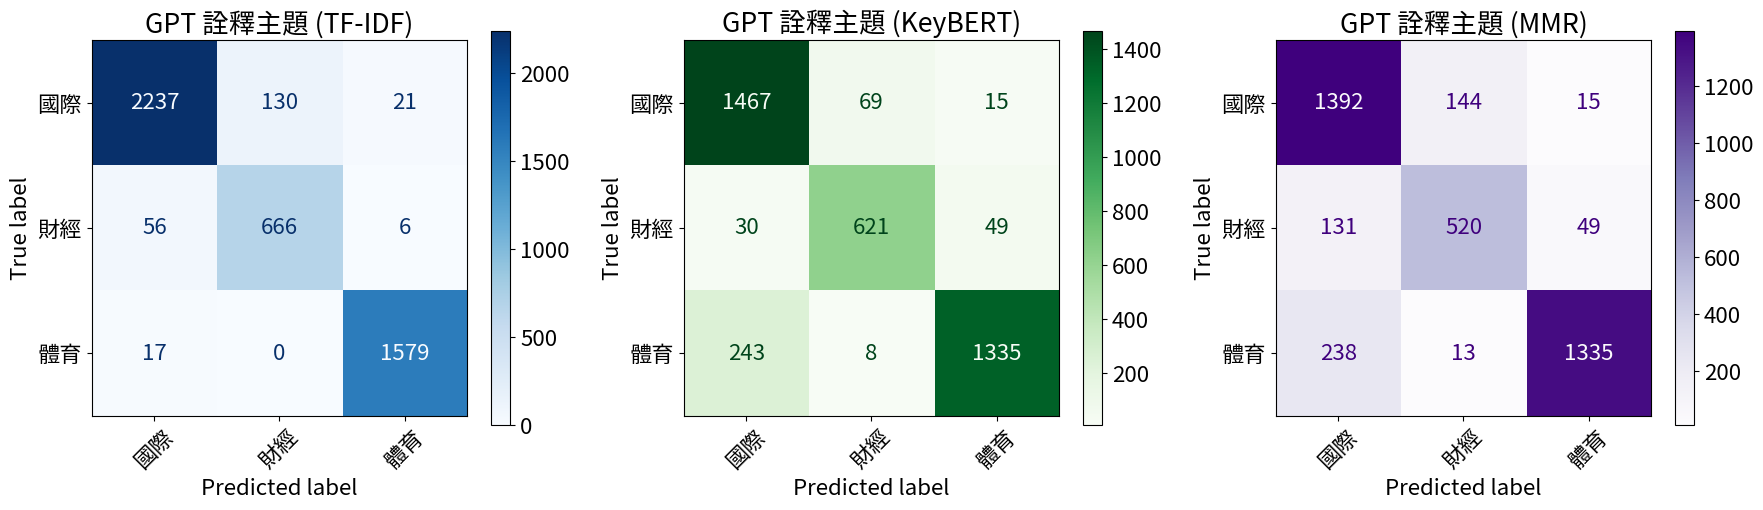

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Âª∫Á´ã‰∏âÁµÑË©ï‰º∞Ë≥áÊñôÔºàÂéªÈô§Áº∫ÂÄºÔºâ
df1 = ebc[['artCatagory', 'gpt_topic']].dropna()
df2 = ebc[['artCatagory', 'gpt_rep_topic']].dropna()
df3 = ebc[['artCatagory', 'gpt_MMR_topic']].dropna()

# ÊåáÂÆöË¶ÅÁµ±‰∏ÄÁöÑÊ®ôÁ±§ÈõÜÔºàÁ¢∫‰øù‰∏âÂÄãÊ∑∑Ê∑ÜÁü©Èô£ÂèØÊØîËºÉÔºâ
labels = sorted(set(df1['artCatagory']) | set(df2['artCatagory']) | set(df3['artCatagory']))

# Âª∫Á´ãÊ∑∑Ê∑ÜÁü©Èô£
cm1 = confusion_matrix(df1['artCatagory'], df1['gpt_topic'], labels=labels)
cm2 = confusion_matrix(df2['artCatagory'], df2['gpt_rep_topic'], labels=labels)
cm3 = confusion_matrix(df3['artCatagory'], df3['gpt_MMR_topic'], labels=labels)

# Áï´Âúñ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GPT È†êË®≠ÔºàTF-IDFÔºâ
ConfusionMatrixDisplay(cm1, display_labels=labels).plot(ax=axes[0], xticks_rotation=45, cmap='Blues', values_format='d')
axes[0].set_title("GPT Ë©ÆÈáã‰∏ªÈ°å (TF-IDF)")

# GPT + KeyBERT
ConfusionMatrixDisplay(cm2, display_labels=labels).plot(ax=axes[1], xticks_rotation=45, cmap='Greens', values_format='d')
axes[1].set_title("GPT Ë©ÆÈáã‰∏ªÈ°å (KeyBERT)")

# GPT + MMR
ConfusionMatrixDisplay(cm3, display_labels=labels).plot(ax=axes[2], xticks_rotation=45, cmap='Purples', values_format='d')
axes[2].set_title("GPT Ë©ÆÈáã‰∏ªÈ°å (MMR)")

plt.tight_layout()
plt.show()
